# XGBoost 电力负荷预测模型

此Jupyter Notebook实现了基于XGBoost的短期电力负荷预测。
代码包括数据加载、预处理、模型训练、多步滚动预测、模型评估以及结果可视化（特征重要性、预测值对比、趋势对比）。

## 0. 准备工作与依赖库导入

In [31]:
# 从 google.colab 库中导入 drive 模块
# 这个模块提供了与 Google Drive 交互的功能，例如挂载（mount）文件系统
from google.colab import drive
# 调用 drive 模块的 mount 方法将 Google Drive 挂载到 Colab 的虚拟机上
# '/content/gdrive' 是挂载的目标路径，挂载成功后，Google Drive 的内容将可以在此路径下访问
# 执行这行代码会弹出一个授权提示，需要用户登录 Google 账号并授权访问 Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 解决Matplotlib中文显示问题，使用SimHei或Microsoft YaHei字体
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子，确保结果可复现
np.random.seed(42)

## 1. 辅助函数定义

In [33]:
# 定义安全平均绝对百分比误差（MAPE）函数，添加epsilon避免除以零。
def safe_mape(y_true, y_pred, epsilon=1e-8):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # 计算MAPE，使用y_true + epsilon作为分母
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon)))

## 2. 数据加载与预处理

In [34]:
# 数据加载与预处理函数
def load_and_preprocess_data(data_path, target_column='value'):
    try:
        # 尝试加载CSV文件
        df = pd.read_csv(data_path)
        print("数据集加载成功！")
        print(f"数据集形状：{df.shape}")

        # 移除可能存在的无用索引列'Unnamed: 0'
        if 'Unnamed: 0' in df.columns:
            df = df.drop(columns=['Unnamed: 0'])
            print("已移除无用的'Unnamed: 0'列")

        # 检查目标列是否存在
        if target_column not in df.columns:
            raise ValueError(f"目标列'{target_column}'不存在")

        # 分离特征X和目标y
        X = df.drop(columns=[target_column])
        y = df[target_column]

        # 识别分类特征和数值特征
        categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

        print(f"\n分类特征：{categorical_features}")
        print(f"数值特征：{numerical_features}")

        # 使用ColumnTransformer构建预处理管道
        preprocessor = ColumnTransformer(
            transformers=[
                # 数值特征：均值填充缺失值，然后进行标准化 (StandardScaler)
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())
                ]), numerical_features),
                # 分类特征：使用OneHotEncoder进行独热编码
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ]
        )

        # 应用预处理器并获取处理后的特征名
        X_processed = preprocessor.fit_transform(X)
        feature_names = preprocessor.get_feature_names_out()
        # 清理特征名，使其更适合XGBoost（去除双下划线和空格）
        feature_names = [name.replace('__', '_').replace(' ', '_') for name in feature_names]

        # 将处理后的特征转换为DataFrame
        X_processed = pd.DataFrame(
            X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed,
            columns=feature_names
        )

        # 划分训练集和测试集 (70%训练，30%测试)
        X_train, X_test, y_train, y_test = train_test_split(
            X_processed, y, test_size=0.3, random_state=42
        )

        return X_train, X_test, y_train, y_test, feature_names

    except FileNotFoundError:
        print(f"错误：文件不存在 - {data_path}")
        # 如果在Jupyter中运行，可以移除exit()以避免终止内核
        # exit()
        return None, None, None, None, None
    except Exception as e:
        print(f"数据预处理错误：{str(e)}")
        # exit()
        return None, None, None, None, None

## 3. 模型训练

In [35]:
# XGBoost 模型训练函数
def train_xgboost_model(X_train, y_train):
    # 初始化XGBoost回归模型，设置参数进行优化（例如，降低n_jobs=1确保单线程训练，方便调试或特定环境）
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', # 目标函数：回归任务的均方误差
        n_estimators=300,             # 树的数量
        max_depth=6,                  # 树的最大深度
        learning_rate=0.05,           # 学习率
        subsample=0.8,                # 训练样本比例
        colsample_bytree=0.8,         # 每次迭代使用的特征比例
        random_state=42,
        n_jobs=1                      # 设置为单线程训练
    )

    print("\n开始训练XGBoost模型...")
    # 拟合模型
    xgb_model.fit(X_train, y_train)
    return xgb_model

## 4. 多步滚动预测

In [36]:
# 多步滚动预测函数
def multi_step_forecast(model, X_test, y_test, steps=4):
    """
    多步滚动预测：批量计算R²以避免单样本问题
    """
    y_pred_steps = []
    # 复制测试数据并重置索引，确保可以正确访问
    test_data = X_test.copy().reset_index(drop=True)
    true_values = y_test.reset_index(drop=True)

    # 对前steps个样本进行逐个预测（滚动预测模拟）
    for step in range(steps):
        # 预测单步样本
        y_pred_step = model.predict(test_data.iloc[step:step+1])
        y_pred_steps.append(y_pred_step[0])

    # 返回所有预测步的预测值和对应的真实值，用于后续评估
    return np.array(y_pred_steps), true_values.iloc[:steps]

## 5. 模型评估与可视化

In [37]:
# 模型评估与可视化函数
def evaluate_model(model, X_test, y_test, feature_names):

    # 5.1 常规单步预测评估
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = safe_mape(y_test, y_pred)


    print(f"均方误差（MSE）：{mse:.4f}")
    print(f"均方根误差（RMSE）：{rmse:.4f}")
    print(f"决定系数（R²）：{r2:.4f}（越接近1越好）")
    print(f"平均绝对百分比误差（MAPE）：{mape:.4f}（越低越好）")

    # 5.2 多步滚动预测评估
    steps = 4  # 可自定义预测步数
    # 调用多步预测函数
    y_pred_steps, y_true_steps = multi_step_forecast(model, X_test, y_test, steps)

    # 批量计算整体R²
    overall_r2 = r2_score(y_true_steps, y_pred_steps)

    # 准备多步预测指标数据，以便格式化输出
    multi_step_metrics = []
    for i in range(steps):
        # 计算每一步的评估指标
        step_mse = mean_squared_error([y_true_steps.iloc[i]], [y_pred_steps[i]])
        step_rmse = np.sqrt(step_mse)
        step_mae = np.mean(np.abs(y_true_steps.iloc[i] - y_pred_steps[i]))
        step_mape = safe_mape([y_true_steps.iloc[i]], [y_pred_steps[i]])

        multi_step_metrics.append([
            f"第{i+1}步预测结果指标：",
            f"{step_mse:.12f}",
            f"{step_rmse:.12f}",
            f"{step_mae:.12f}",
            f"{step_mape*100:.2f}%",
            f"{overall_r2*100:.2f}%" # 注意：R2是整体R2，与单步R2不同
        ])

    # 优化多步预测指标输出格式，使其对齐美观
    print("\n===== 多步预测指标 ======")
    header = ["测试集指标", "MSE", "RMSE", "MAE", "MAPE", "R2"]
    print("\t".join(header)) # 打印表头
    for row in multi_step_metrics:
        print("\t".join(row)) # 打印每行数据

    # 显示整体多步预测R²
    print(f"\n整体多步预测R²：{overall_r2:.4f}")

    # 5.3 结果可视化

    # 1. 特征重要性图（前15个重要特征）
    plt.figure(figsize=(10, 6))
    importance = model.feature_importances_
    # 获取前15个最重要的特征索引
    indices = np.argsort(importance)[-15:]
    values = importance[indices]
    # 绘制水平条形图
    plt.barh(range(len(indices)), values, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(indices))))
    # 设置Y轴标签为特征名称
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('特征重要性')
    plt.title('XGBoost特征重要性（前15名）')
    # 在条形图上添加数值标签
    for i, v in enumerate(values):
        plt.text(v + 0.005, i, f"{v:.2f}", va='center', fontsize=9)
    plt.tight_layout()
    plt.show()

    # 2. 预测值 vs 实际值（随机抽取50个样本）
    plt.figure(figsize=(12, 6))
    # 随机抽取50个样本索引
    sample_indices = np.random.choice(len(y_test), 50, replace=False)
    # 绘制散点图对比实际值和预测值
    plt.scatter(range(50), y_test.iloc[sample_indices], label='实际值', color='#e63946', alpha=0.7)
    plt.scatter(range(50), y_pred[sample_indices], label='预测值', color='#457b9d', alpha=0.7)
    plt.xlabel('样本索引')
    plt.ylabel('电力负荷值')
    plt.title('预测值与实际值对比（随机50样本）')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. 负荷趋势对比（前200个测试样本的时间序列）
    plt.figure(figsize=(12, 6))
    # 绘制前200个样本的实际值和预测值曲线
    plt.plot(range(200), y_test.iloc[:200].values, label='实际值', color='#e63946')
    plt.plot(range(200), y_pred[:200], label='预测值', color='#457b9d')
    plt.xlabel('时间序列（前200测试样本）')
    plt.ylabel('电力负荷值')
    plt.title('负荷趋势预测对比')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 6. 主程序入口

数据集加载成功！
数据集形状：(75552, 15)
已移除无用的'Unnamed: 0'列

分类特征：[]
数值特征：['weather_status', 'temperature', 'humidity', 'wind_speed', 'wind_direction_angle', 'pressure', 'visibility', 'precipitation', 'light', 'holiday', 'minute', 'week', 'year']

开始训练XGBoost模型...


/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


均方误差（MSE）：314470.6442
均方根误差（RMSE）：560.7768
决定系数（R²）：0.8985（越接近1越好）
平均绝对百分比误差（MAPE）：0.0882（越低越好）

===== 多步预测指标 ======
测试集指标	MSE	RMSE	MAE	MAPE	R2
第1步预测结果指标：	13626.233607817219	116.731459375000	116.731459375000	2.31%	69.12%
第2步预测结果指标：	9369.005840640673	96.793625000000	96.793625000000	1.64%	69.12%
第3步预测结果指标：	3530.325671195619	59.416543750000	59.416543750000	1.12%	69.12%
第4步预测结果指标：	762029.399410595652	872.942953125000	872.942953125000	12.23%	69.12%

整体多步预测R²：0.6912


/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:70: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

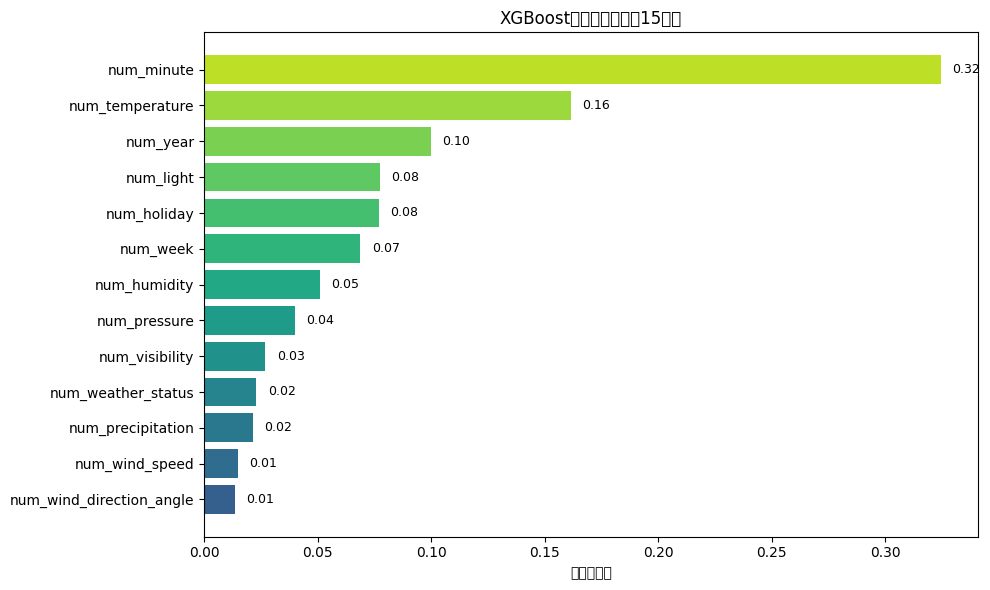

/tmp/ipython-input-37-2837609831.py:84: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:84: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:84: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:84: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:84: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:84: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:84: UserWarning: Glyph 36127 (\N{CJK UNIFIED I

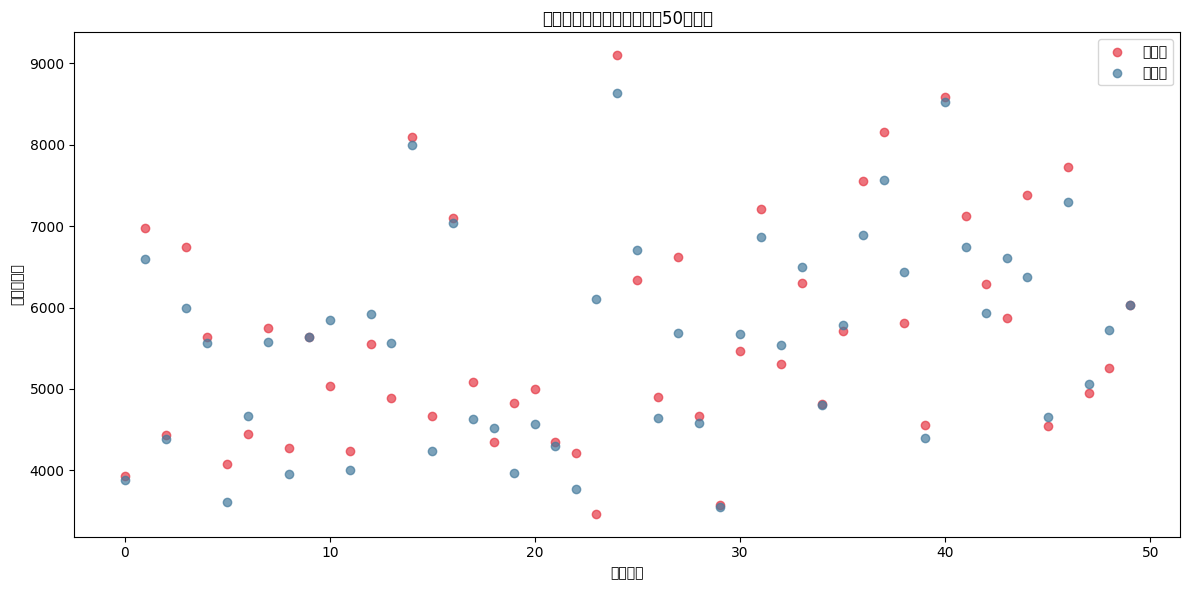

/tmp/ipython-input-37-2837609831.py:96: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:96: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:96: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:96: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:96: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:96: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-2837609831.py:96: UserWarning: Glyph 27979 (\N{CJK UNIFIED I

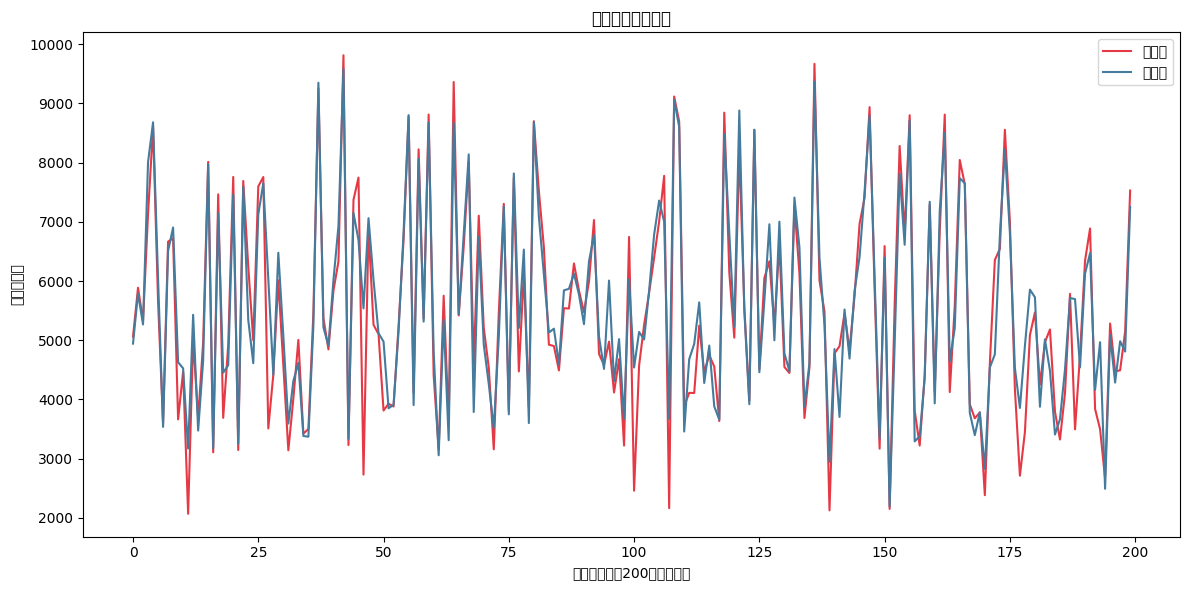

In [38]:
# 主函数入口，执行整个预测流程
if __name__ == "__main__":
    # 数据文件路径（请根据实际情况修改）
    DATA_PATH = "/content/gdrive/MyDrive/ElectricPowerTraining/data/new_data.csv"
    TARGET_COLUMN = "value"

    # 1. 加载并预处理数据
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess_data(DATA_PATH, TARGET_COLUMN)

    # 确保数据加载成功
    if X_train is not None:
        # 2. 训练模型
        model = train_xgboost_model(X_train, y_train)
        # 3. 评估模型并可视化结果
        evaluate_model(model, X_test, y_test, feature_names)
    else:
        print("数据加载或预处理失败，无法继续执行。")